# **1. 데이터 차원**
- 데이터 자체는 충분함
- 불균형 데이터 -> Data Augmentation
- 데이터 범위(scale) 조정: 정규화/규제화/표준화

# **2. 알고리즘 차원**
- 주로 적은 learning rate를 적용하는 경우 batch size 또한 작게 설정하는 것이 학습 성능 향상에 더 도움이 된다고 한다. 따라서, 이를 실험해 보고자 한다.

- 학습률(learning rate)
    - lr scheduling
    - 초기 lr: 1e-4
    - min_lr: 1e-10
- 활성화 함수/손실함수
    - 활성화 함수: softmax
    - 손실 함수: CrossEntropyLoss
- 배치/ Epoch
    - 충분한 학습이 이루어질 수 있도록 Epoch 수 증가
    - batch size: 64(128 -> 64)
    - Epoch: 200

# **3. 하드웨어 차원**
- 역전파처럼 복잡한 미적분 연산의 경우 병렬 연산을 해야 속도/ 정확도 증가
- 장치를 cpu에서 gpu로 변경

In [1]:
### 필요한 라이브러리 준비

import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
import copy
import argparse

from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from ipywidgets import interact
from module.pytorchtools import EarlyStopping # 사용자 정의 모듈
                                              # 외부 py파일을 모듈로 import하여 EarlyStopping 함수 사용

In [2]:
### gpu 장치 확인
print(torch.__version__) 

1.12.1+cu116


### **DataLoader**

In [3]:
train_data_dir = './DataSet/archive/train/'
train_data_df = pd.read_csv(os.path.join(train_data_dir,'train.csv'))

# 분류에 사용할 class 정의(7개의 감정들)
feelings_list = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

In [4]:
IMAGE_SIZE = 48

### 이미지 파일 경로를 리스트 형태로 저장하기 위한 함수
def list_image_file(data_dir,sub_dir):
    image_files = []
    
    images_dir = os.path.join(data_dir,sub_dir)
    for file_path in os.listdir(images_dir):
        image_files.append(os.path.join(sub_dir,file_path))
    return image_files

In [5]:
### 학습 데이터셋 클래스
class Feeling_dataset(Dataset):
    ### 생성자
    def __init__(self,data_dir,transform = None):
        self.data_dir = data_dir # 데이터가 저장된 상위 directory
        angry_imgs = list_image_file(data_dir,'angry')
        disgust_imgs = list_image_file(data_dir,'disgust')
        fear_imgs = list_image_file(data_dir,'fear')
        happy_imgs = list_image_file(data_dir,'happy')
        neutral_imgs = list_image_file(data_dir,'neutral')
        sad_imgs = list_image_file(data_dir,'sad')
        surprise_imgs = list_image_file(data_dir,'surprise')
        
        # 모든 사진들의 경로를 하나의 리스트에 저장
        self.files_path = angry_imgs + disgust_imgs + fear_imgs + happy_imgs + neutral_imgs + sad_imgs + surprise_imgs
        self.transform = transform
    
    ### 데이터 개수 확인
    def __len__(self):
        return len(self.files_path) # 전체 데이터 개수
    
    ### getitem
    def __getitem__(self,index):
        # image(feature data)
        image_file = os.path.join(self.data_dir,self.files_path[index])
        image = cv2.imread(image_file)
        image = cv2.resize(image,dsize = (IMAGE_SIZE,IMAGE_SIZE),interpolation = cv2.INTER_LINEAR)
        image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
        
        # feeling(target data)
        target = feelings_list.index(self.files_path[index].split(os.sep)[0])
        
        if self.transform:
            image = self.transform(image) # feature data에 대해서만 데이터 변형 수행
            target = torch.Tensor([target]).long()
            
        return {'image':image,'target':target}

In [6]:
### Transformation

# 학습 feature data 변환
train_transformer = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomHorizontalFlip(), # 수평으로 뒤집기
    transforms.RandomVerticalFlip(), # 수직으로 뒤집기
    transforms.ToTensor(), # 텐서로 변환
    transforms.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225]) # 정규화
])

# 검증 feature data 변환
val_transformer = transforms.Compose([
    transforms.ToTensor(), # 텐서로 변환
    transforms.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225]) # 정규화
])

In [7]:
### 데이터로더 구현
def build_dataloader(train_data_dir,val_data_dir):
    dataloaders = {}
    train_dset = Feeling_dataset(train_data_dir,train_transformer)
    dataloaders['train'] = DataLoader(train_dset,batch_size = 64,shuffle = True, drop_last = True)
    
    val_dset = Feeling_dataset(val_data_dir,val_transformer)
    dataloaders['val'] = DataLoader(val_dset,batch_size = 64,shuffle = False, drop_last = False)
    
    return dataloaders

In [8]:
train_data_dir = './DataSet/archive/train/'
val_data_dir = train_data_dir = './DataSet/archive/valid/'
dataloaders = build_dataloader(train_data_dir,val_data_dir)

### **Modeling**

In [9]:
from torchsummary import summary

In [10]:
### 모델 생성 함수
# 기존의 VGG19 모델 호출 -> head 부분 수정
def build_vgg19_based_model():
    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu') # gpu 할당
    model = models.vgg19(pretrained = True) # 이미 학습된 vgg19 모델 불러오기
    # 일반 NN Layer(FC Layer)
    model.avgpool = nn.AdaptiveAvgPool2d(output_size = (1,1)) # 각 구역의 평균값 출력
    model.classifier = nn.Sequential(
        nn.Flatten(), # 평탄화
        nn.Linear(512,256), # 512 -> 256
        nn.ReLU(), # 활성화 함수
        nn.Dropout(0.1), # 과적합 방지
        nn.Linear(256,7), # 256 -> 7(7개의 감정으로 분류되니)
        nn.Softmax() # 활성화 함수(각 클래스에 속할 확률 추정)
    )
    
    return model.to(device)

### **Estimation**

In [11]:
### 모델 검증을 위한 accuracy

@torch.no_grad() 
def get_accuracy(image,target,model):
    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu') # gpu 할당
    batch_size = image.shape[0] 
    prediction = model(image).to(device) # 예측 
    _,pred_label = torch.max(prediction,dim = 1) # 예측이 어느 클래스에 속하는지 확률이 가장 높은 1개 선택
    is_correct = (pred_label == target)
    
    return is_correct.cpu().numpy().sum() / batch_size

### **Training**

In [12]:
### Epoch을 1번 수행

def train_one_epoch(dataloaders, model, optimizer, loss_function, device):
    losses = {}  # loss값 저장
    accuracies = {} # 정확도 계산
    
    for tv in ["train", "val"]: 
        ### loss, accuracy 갱신
        running_loss = 0.0 
        running_correct = 0.0
        
        if tv == "train":
            model.train() # 학습
        else:
            model.eval() # 평가
            
            
        for index, batch in enumerate(dataloaders[tv]): 
            image = batch['image'].to(device) # feature data(이미지)
            label = batch['target'].squeeze(dim = 1).to(device) # label data(감정), 1차원으로 차원 축소
            
            ### 역전파 적용
            with torch.set_grad_enabled(tv == 'train'):
                prediction = model(image) # label 예측
                loss = loss_func(prediction, label) # loss 값 계산
                
                if tv == 'train':
                    optimizer.zero_grad() # gradient를 0으로 초기화
                    loss.backward() # 역전파 적용
                    optimizer.step() # 가중치 업데이트
                    
            running_loss += loss.item()
            running_correct += get_accuracy(image, label, model)
            
            ### 학습 과정 monitoring
            if tv == 'train':
                if index % 50 == 0:
                    print(f"{index}/{len(dataloaders['train'])} - Running loss: {loss.item()}")
                    
        ### loss, accuracy 저장            
        losses[tv] = running_loss / len(dataloaders[tv])
        accuracies[tv] = running_correct / len(dataloaders[tv])
        
    return losses, accuracies

In [13]:
### 학습이 잘 된 모델 저장
def save_best_model(model_state,model_name,save_dir = './best_model'):
    os.makedirs(save_dir,exist_ok = True) # 경로 존재 시 덮어쓰기, 없는 경우 새로 생성
    torch.save(model_state,os.path.join(save_dir,model_name)) # 모델 저장

In [14]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu') # 장치 얻어오기

### 경로 설정
train_data_dir = './DataSet/archive/train/'
val_data_dir = './DataSet/archive/valid/'

### 필요한 요소들 준비
dataloaders = build_dataloader(train_data_dir,val_data_dir)
model = build_vgg19_based_model().to(device)
loss_func = nn.CrossEntropyLoss(reduction = 'mean').to(device)
optimizer = torch.optim.Adam(model.parameters(),lr = 1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode = 'min', patience = 5, factor = 0.1,
                                                       min_lr = 1e-10,verbose = True)  # lr scheduling
early_stopping = EarlyStopping(patience = 10, verbose = False) # 조기 종료(사용자 정의 모듈)

c:\users\bin\appdata\local\programs\python\python38\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
c:\users\bin\appdata\local\programs\python\python38\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [15]:
num_epochs = 200

best_acc = 0.0
train_loss,train_accuracy = [],[]
val_loss,val_accuracy = [],[]

for epoch in range(num_epochs):
    ### 1 Epoch 수행
    losses, accuracies = train_one_epoch(dataloaders, model, optimizer, loss_func, device)
    
    # LR Scheduling
    scheduler.step(losses['val']) # 1 Epoch 수행 후 learning rate 조정
    
    # EarlyStopping
    early_stopping(losses['val'], model) # 현재 과적합 상황 추적
    if early_stopping.early_stop: # 조건 만족 시 조기 종료
        break
        
    train_loss.append(losses['train'])
    val_loss.append(losses['val'])
    train_accuracy.append(accuracies['train'])
    val_accuracy.append(accuracies['val'])
    
    print(f"{epoch+1}/{num_epochs}-Train Loss:{losses['train']}, Val Loss:{losses['val']}")
    print(f"{epoch+1}/{num_epochs}-Train Acc:{accuracies['train']}, Val Acc:{accuracies['val']}")
    
    # deepcopy: 배열의 내부 객체까지 복사를 해서 사용
    # copy: 배열의 내부 객체까지 깊은 복사를 해주지 않음
    if (epoch > 3) and (accuracies['val'] > best_acc):
        best_acc = accuracies['val']
        best_model = copy.deepcopy(model.state_dict()) 
        save_best_model(best_model, f'model_{epoch+1:02d}.pth')

print(f'Bset Accuracy: {best_acc}')

c:\users\bin\appdata\local\programs\python\python38\lib\site-packages\torch\nn\modules\container.py:139: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


0/455 - Running loss: 1.950528860092163
50/455 - Running loss: 1.8912782669067383
100/455 - Running loss: 1.7475979328155518
150/455 - Running loss: 1.915421485900879
200/455 - Running loss: 2.056046485900879
250/455 - Running loss: 2.024796485900879
300/455 - Running loss: 1.962296485900879
350/455 - Running loss: 1.977921485900879
400/455 - Running loss: 2.024796485900879
450/455 - Running loss: 2.024796485900879
1/200-Train Loss:1.9516240450052114, Val Loss:1.9987549154382003
1/200-Train Acc:0.21583104395604397, Val Acc:0.16666666666666666
0/455 - Running loss: 1.977921485900879
50/455 - Running loss: 1.993546485900879
100/455 - Running loss: 1.9622963666915894
150/455 - Running loss: 2.009171485900879
200/455 - Running loss: 2.040421485900879
250/455 - Running loss: 1.931046485900879
300/455 - Running loss: 2.071671485900879
350/455 - Running loss: 1.931046485900879
400/455 - Running loss: 2.009171485900879
450/455 - Running loss: 2.024796485900879
2/200-Train Loss:1.99862887885544

15/200-Train Loss:1.998628888287387, Val Loss:1.9987549154382003
15/200-Train Acc:0.1667925824175824, Val Acc:0.16666666666666666
0/455 - Running loss: 1.9935463666915894
50/455 - Running loss: 1.931046485900879
100/455 - Running loss: 1.977921485900879
150/455 - Running loss: 2.040421485900879
200/455 - Running loss: 2.009171485900879
250/455 - Running loss: 1.9466713666915894
300/455 - Running loss: 1.993546485900879
350/455 - Running loss: 2.056046485900879
400/455 - Running loss: 2.009171485900879
450/455 - Running loss: 1.931046485900879
16/200-Train Loss:1.99876624751877, Val Loss:1.9987549154382003
16/200-Train Acc:0.16665521978021977, Val Acc:0.16666666666666666
0/455 - Running loss: 1.868546485900879
50/455 - Running loss: 2.040421485900879
100/455 - Running loss: 2.009171485900879
150/455 - Running loss: 1.993546485900879
200/455 - Running loss: 1.931046485900879
250/455 - Running loss: 2.040421485900879
300/455 - Running loss: 2.024796485900879
350/455 - Running loss: 2.0560

300/455 - Running loss: 1.9466713666915894
350/455 - Running loss: 1.9779213666915894
400/455 - Running loss: 2.071671485900879
450/455 - Running loss: 2.056046485900879
30/200-Train Loss:1.9985945442220667, Val Loss:1.9987549154382003
30/200-Train Acc:0.16682692307692307, Val Acc:0.16666666666666666
0/455 - Running loss: 1.962296485900879
50/455 - Running loss: 1.962296485900879
100/455 - Running loss: 2.040421485900879
150/455 - Running loss: 1.946671485900879
200/455 - Running loss: 2.009171485900879
250/455 - Running loss: 1.931046485900879
300/455 - Running loss: 2.009171485900879
350/455 - Running loss: 2.009171485900879
400/455 - Running loss: 2.009171485900879
450/455 - Running loss: 1.852921485900879
31/200-Train Loss:1.9986288890733823, Val Loss:1.9987549154382003
31/200-Train Acc:0.1667925824175824, Val Acc:0.16666666666666666
0/455 - Running loss: 2.056046485900879
50/455 - Running loss: 1.946671485900879
100/455 - Running loss: 2.009171485900879
150/455 - Running loss: 1.9

KeyboardInterrupt: 

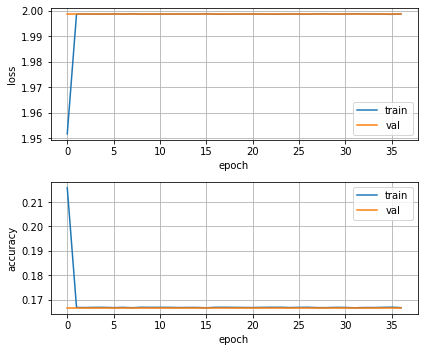

In [16]:
### Loss, Accuracy 시각화

plt.figure(figsize = (6,5))

# Loss
plt.subplot(211)
plt.plot(train_loss,label = "train")
plt.plot(val_loss,label = "val")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.grid("on")
plt.legend()

# Accuracy
plt.subplot(212)
plt.plot(train_accuracy,label = "train")
plt.plot(val_accuracy,label = "val")
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.grid("on")
plt.legend()

plt.tight_layout()

- learning rate가 batch size에 비해 지나치게 높은 것을 확인할 수 있다.